# Picking the best longitude

### Here we treat longitude as the only free parameter to separate our flower observations into two groups: east vs. west. 
### If there were only one response, we could just try to find the longitude that maximizes a t-test. 
### Since there are 3 response variables (i.e. 3 color components), we will find the longitude that maximizes Hotelling's $T^2$, a multivariate stat.

### Imports

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from scipy.stats import ttest_ind

# for converting cielab to LCh
from colormath.color_objects import LabColor, LCHabColor
from colormath.color_conversions import convert_color

# multivariate t-test package
from pingouin import multivariate_ttest

### Read in data

In [2]:
color_df = pd.read_csv('../datasets/1-clusters/cluster1.csv')

### Pick random image if duplicates for an observation

In [3]:
color_df_reduced = (
    color_df.groupby("gbifID", sort=False, group_keys=False)
    .apply(lambda x: x.sample(1))
    .reset_index(drop=True)
)
color_df_reduced

/var/folders/qh/c7rwx84921n2kznn09zb2pnh0000gn/T/ipykernel_83859/411184798.py:3: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: x.sample(1))


,image_idx,hex,rgb,hsl,lab,gbifID,identifier,latitude,longitude
0,0,#d4b4de,"(212, 180, 222)","(0.7936507936507936, 0.38888888888888895, 0.78...","(197, 147, 111)",923911394,https://inaturalist-open-data.s3.amazonaws.com...,48.826305,-102.092171
1,2,#cdb2cb,"(205, 178, 203)","(0.8456790123456791, 0.21259842519685052, 0.75...","(193, 142, 119)",923910407,https://inaturalist-open-data.s3.amazonaws.com...,43.613086,-73.057076
2,4,#bba6d7,"(187, 166, 215)","(0.738095238095238, 0.3798449612403101, 0.7470...","(182, 145, 106)",899970365,https://inaturalist-open-data.s3.amazonaws.com...,43.066871,-87.890565
3,7,#9984ae,"(153, 132, 174)","(0.75, 0.2058823529411765, 0.6000000000000001)","(149, 144, 109)",891778924,https://inaturalist-open-data.s3.amazonaws.com...,42.140556,-87.831643
4,9,#ba9edb,"(186, 158, 219)","(0.7431693989071038, 0.4586466165413533, 0.739...","(177, 150, 101)",891760719,https://inaturalist-open-data.s3.amazonaws.com...,38.679240,-97.990035
...,...,...,...,...,...,...,...,...,...
16582,41059,#9f8fc0,"(159, 143, 192)","(0.7210884353741497, 0.27999999999999997, 0.65...","(159, 144, 105)",1024218211,https://inaturalist-open-data.s3.amazonaws.com...,41.569419,-88.150552
16583,41060,#b47eb0,"(180, 126, 176)","(0.845679012345679, 0.2647058823529413, 0.6000...","(152, 157, 110)",1024202810,https://inaturalist-open-data.s3.amazonaws.com...,45.057871,-87.168277
16584,41061,#ae95c8,"(174, 149, 200)","(0.7483660130718954, 0.31677018633540366, 0.68...","(167, 147, 105)",1024200169,https://inaturalist-open-data.s3.amazonaws.com...,42.921738,-88.026752
16585,41063,#c8b9b1,"(200, 185, 177)","(0.057971014492753624, 0.17293233082706772, 0....","(194, 132, 134)",1024198670,https://inaturalist-open-data.s3.amazonaws.com...,40.791723,-80.492498


### split Lab into separate components and get it into the "literal" metric rather than the opencv default of 0-255

In [4]:
L = [(int(i.strip('()').split(', ')[0])) for i in color_df_reduced.lab]
L = (np.array(L) / 255.0) * 100.0  
color_df_reduced['L'] = L
a = [(int(i.strip('()').split(', ')[1])) for i in color_df_reduced.lab]
a = np.array(a) - 128.0  
color_df_reduced['a'] = a
b = [(int(i.strip('()').split(', ')[2])) for i in color_df_reduced.lab]
b = np.array(b) - 128.0
color_df_reduced['b'] = b

### get LCh values as well

In [5]:
lab_vals = np.array(color_df_reduced[['L','a','b']])

lch_arr = np.empty_like(lab_vals)
for i, (L_, a_, b_) in enumerate(lab_vals):
    # had to think carefully here -- these look like the correct defaults
    # rather than d50 illuminant because of I used opencv at its default
    lab = LabColor(L_, a_, b_, observer='2', illuminant='d65') 
    lch = convert_color(lab, LCHabColor)
    lch_arr[i] = lch.get_value_tuple()

In [6]:
color_df_reduced['lch_l'] = lch_arr[:,0]
color_df_reduced['lch_c'] = lch_arr[:,1]
color_df_reduced['lch_h'] = lch_arr[:,2]

# Use pinguoin's implementation of multivariate t-testing with Hotelling's $T^2$

## First on CIELAB values

In [7]:
t2s = []
lons = []
for focal_lon in np.linspace(color_df_reduced.longitude.min()+1, color_df_reduced.longitude.max()-1,1000):
    west  = color_df_reduced.longitude < focal_lon
    east  = ~west
    west_df = color_df_reduced[west][['L','a','b']]
    east_df = color_df_reduced[east][['L','a','b']]
    if (len(west_df) > 125) and (len(east_df) > 125):
        res = multivariate_ttest(west_df,east_df)
        t2s.append(res.T2.iloc[0])
        lons.append(focal_lon)

In [8]:
best_lon = lons[np.argmax(t2s)]
best_lon

np.float64(-97.68742601601602)

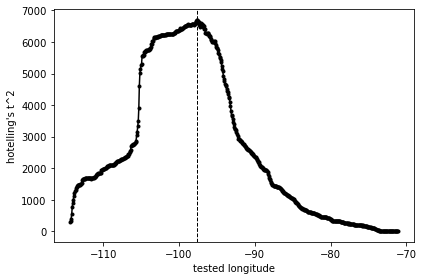

In [9]:
plt.plot(lons, t2s, marker='o', ms=3,c='black')
plt.axvline(best_lon, ls='--', lw=1, color='k')
plt.xlabel('tested longitude')
plt.ylabel('hotelling\'s t^2')
plt.tight_layout()
plt.savefig('../figures/figure_puzzling/hotelling_lab.pdf',dpi=300)
plt.show()

## Now on LCh values

In [10]:
t2s = []
lons = []
for focal_lon in np.linspace(color_df_reduced.longitude.min()+1, color_df_reduced.longitude.max()-1,1000):
    west  = color_df_reduced.longitude < focal_lon
    east  = ~west
    west_df = color_df_reduced[west][['lch_l','lch_c','lch_h']]
    east_df = color_df_reduced[east][['lch_l','lch_c','lch_h']]
    if (len(west_df) > 125) and (len(east_df) > 125):
        res = multivariate_ttest(west_df,east_df)
        t2s.append(res.T2.iloc[0])
        lons.append(focal_lon)

In [11]:
best_lon = lons[np.argmax(t2s)]
best_lon

np.float64(-97.68742601601602)

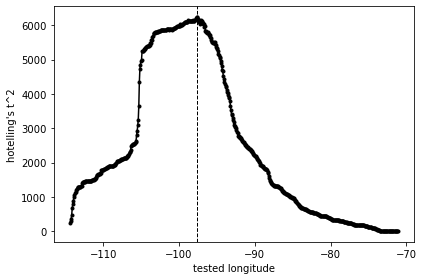

In [12]:
plt.plot(lons, t2s, marker='o', ms=3,c='black')
plt.axvline(best_lon, ls='--', lw=1, color='k')
plt.xlabel('tested longitude')
plt.ylabel('hotelling\'s t^2')
plt.tight_layout()
plt.savefig('../figures/figure_puzzling/hotelling_lab.pdf',dpi=300)
plt.show()

# Re-do on scrambled values -- should see no clear signal!

In [13]:
scramble_df = color_df_reduced.copy()

In [14]:
lch_sub = scramble_df[['L','a','b']]

In [15]:
scramble_sub = lch_sub.sample(len(lch_sub)).to_numpy()

In [16]:
scramble_df[['L','a','b']] = scramble_sub

In [17]:
t2s = []
lons = []
for focal_lon in np.linspace(scramble_df.longitude.min()+1, scramble_df.longitude.max()-1,1000):
    west  = scramble_df.longitude < focal_lon
    east  = ~west
    west_df = scramble_df[west][['L','a','b']]
    east_df = scramble_df[east][['L','a','b']]
    if (len(west_df) > 125) and (len(east_df) > 125):
        res = multivariate_ttest(west_df,east_df)
        t2s.append(res.T2.iloc[0])
        lons.append(focal_lon)

In [18]:
best_lon = lons[np.argmax(t2s)]
best_lon

np.float64(-89.12575826926928)

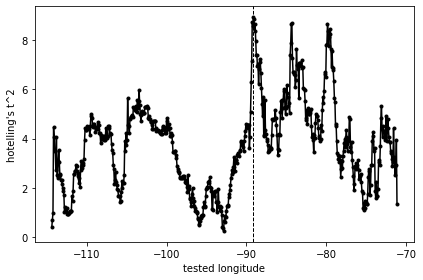

In [19]:
plt.plot(lons, t2s, marker='o', ms=3,c='black')
plt.axvline(best_lon, ls='--', lw=1, color='k')
plt.xlabel('tested longitude')
plt.ylabel('hotelling\'s t^2')
plt.tight_layout()
plt.show()